In [2]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

## Cargar la base de datos

In [3]:
try:
    conn = psycopg2.connect(
        host='localhost',
        user='postgres',
        password='root',
        database='arriendos',
        port='5432'
    )  # type: ignore
    print('Conexión exitosa')
    cur = conn.cursor()
    sql = '''select u.nombre, u.fecha_ingreso, u.precio_pactado, d.departamento, d.id_departamento, 
            p.mes_pago, p.year_pago, p.monto_pago, p.fecha_pago from usuarios u
            join departamentos d on d.id_usuario = u.id_usuario
            join Pagos p on u.id_usuario = p.id_usuario;'''
    cur.execute(sql)
    datos = cur.fetchall()
    columnas = [descripcion[0] for descripcion in cur.description]
    cur.close()
    conn.close()
except Exception as ex:
    print(f'Error: {ex}')
else:
    print('Cerrando sesión')

Conexión exitosa
Cerrando sesión


In [4]:
df = pd.DataFrame(datos, columns=columnas)
#df['monto_pago'].fillna(0)
df.head()

,nombre,fecha_ingreso,precio_pactado,departamento,id_departamento,mes_pago,year_pago,monto_pago,fecha_pago
0,Martha Lucia Barona,2023-01-01,200,QUITO CASA,1,ABR,2024,120.00,2024-04-06
1,Martha Lucia Barona,2023-01-01,200,QUITO CASA,1,MAR,2024,200.00,2024-03-15
2,Martha Lucia Barona,2023-01-01,200,QUITO CASA,1,FEB,2024,200.00,2024-02-26
3,Martha Lucia Barona,2023-01-01,200,QUITO CASA,1,ENE,2024,80.00,2024-02-19
4,Martha Lucia Barona,2023-01-01,200,QUITO CASA,1,ENE,2024,100.00,2024-02-16


## Procesamiento datos

In [5]:
meses_numeros = {'ENE': 1, 'FEB': 2, 'MAR': 3, 'ABR': 4, 'MAY': 5, 'JUN': 6, 'JUL': 7, 'AGO': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DIC': 12}

In [6]:
def pagos():
    # Crear una nueva columna con los números de los meses para todos los registros
    df['mes_numero'] = df['mes_pago'].map(meses_numeros)

    # Crea un dataframe para ver el nombre de los usuarios y sus pagos segun los meses
    df_pagos = df.pivot_table(index=['nombre', 'departamento'], columns='mes_numero', values=['monto_pago', 'fecha_pago'], aggfunc={'monto_pago': 'sum', 'fecha_pago': 'first'})
    df_pagos.columns = df_pagos.columns.swaplevel()
    df_pagos = df_pagos.sort_index(axis=1)

    # Cambia los numeros por el mes
    iniciales_meses = list(map(lambda x: (next(key for key, value in meses_numeros.items() if value == x[0]), x[1]), df_pagos.columns))
    iniciales_meses = list(map(lambda x: (x[0],x[1].replace('fecha_pago', 'fecha')), iniciales_meses))
    iniciales_meses = list(map(lambda x: (x[0],x[1].replace('monto_pago', 'pago')), iniciales_meses))
    df_pagos.columns = pd.MultiIndex.from_tuples(iniciales_meses)
    return df_pagos

pagos()

ENE                 FEB          \
                                           fecha    pago       fecha    pago   
nombre              departamento                                               
Anita Chicaiza      QUITO MEDIA AGUA  2024-01-10  140.00  2024-02-14  140.00   
Emma Simbaña        AMBATO DEP2       2024-01-08  220.00  2024-02-07  220.00   
Fernando Pichucho   AMBATO DEP1       2024-01-22   90.00  2024-03-15  230.00   
Jeremy mestanza     AMBATO LOCAL IME  2024-01-23  200.00  2024-02-26  200.00   
Martha Lucia Barona QUITO CASA        2024-02-19  180.00  2024-02-26  200.00   
Nestor Castro       LAGO AGRIO CASA   2024-02-29  200.00  2024-02-29  200.00   

                                             MAR                 ABR          
                                           fecha    pago       fecha    pago  
nombre              departamento                                              
Anita Chicaiza      QUITO MEDIA AGUA  2024-03-11  140.00  2024-04-07  140.00  
Emma Simbaña        AMBATO DEP2       2024-03-08  220.00  2024-04-08  220.00  
Fernando Pichucho   AMBATO DEP1       2024-03-30  230.00         NaN     NaN  
Jeremy mestanza     AMBATO LOCAL IME  2024-03-28  200.00         NaN     NaN  
Martha Lucia Barona QUITO CASA        2024-03-15  200.00  2024-04-06  120.00  
Nestor Castro       LAGO AGRIO CASA          NaN     NaN         NaN     NaN

In [7]:
#pivot_df.iloc[:,pivot_df.columns.get_level_values(1) == 'fecha']

In [25]:
def deuda(mes='total'):
    pd.options.mode.copy_on_write = True
    df_deuda = df.copy()
    df_deuda['precio_pactado'] = df_deuda['precio_pactado'].astype(float)
    df_deuda['monto_pago'] = df_deuda['monto_pago'].astype(float)
    meses = df_deuda['mes_pago'].unique()
    df_deuda = df_deuda.pivot_table(index=['nombre','precio_pactado','departamento'], columns='mes_pago', values=['monto_pago'], aggfunc={'monto_pago':'sum'})
    df_deuda.columns = df_deuda.columns.swaplevel()
    
    df_deuda = df_deuda.rename(columns={'precio_pactado':'deuda', 'monto_pago': 'pago'})
    df_deuda = df_deuda.fillna(0)

    for elementos in meses:
       df_deuda[(elementos, 'deuda')] = df_deuda.index.get_level_values(1).tolist()
       df_deuda[(elementos, 'deuda')]= df_deuda[(elementos,'deuda' )] - df_deuda[(elementos, 'pago')]

    df_deuda = df_deuda.sort_index(axis=1, ascending=False)

    if mes == 'total':
        deuda_total= df_deuda.loc[:, df_deuda.columns.get_level_values(1) == 'deuda'].sum(axis=1)
        return pd.DataFrame(deuda_total.values, index=[df_deuda.index.get_level_values(2),df_deuda.index.get_level_values(0)], columns=['deuda'])
         
    df_deuda = df_deuda.loc[:,df_deuda.columns.get_level_values(0) == mes]
    pago = df_deuda[(mes,'pago')].tolist()
    deuda = df_deuda[(mes,'deuda')].tolist()
    precio = df_deuda.index.get_level_values(1)
    lista = list(zip(precio,pago,deuda))
    df_deuda = pd.DataFrame(lista, index=[df_deuda.index.get_level_values(2),df_deuda.index.get_level_values(0)], columns=['precio', 'pago', 'deuda'])
    return df_deuda

deuda()

,,deuda
departamento,nombre,
QUITO MEDIA AGUA,Anita Chicaiza,0.0
AMBATO DEP2,Emma Simbaña,0.0
AMBATO DEP1,Fernando Pichucho,370.0
AMBATO LOCAL IME,Jeremy mestanza,200.0
QUITO CASA,Martha Lucia Barona,100.0
LAGO AGRIO CASA,Nestor Castro,400.0


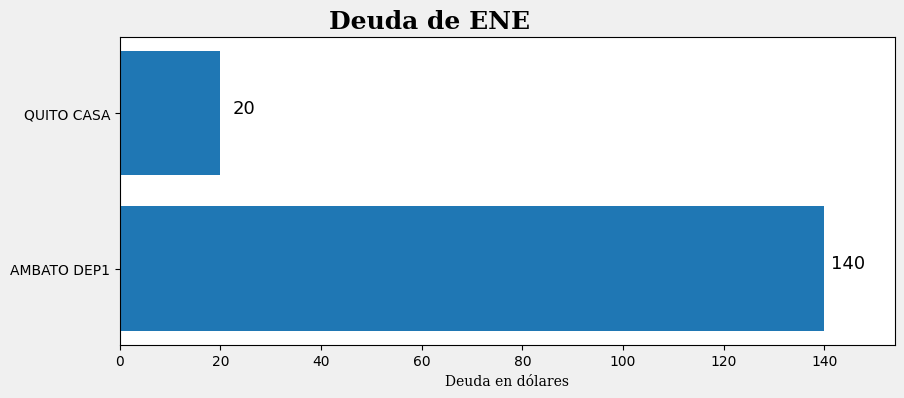

In [27]:
def img_deuda(mes='total'):
    df_meses = deuda(mes)
    df_meses = df_meses[df_meses['deuda'] != 0]
    ancho_maximo = max(df_meses['deuda'])
    fig = plt.figure(figsize=(10,4))
    fig.set_facecolor('#f0f0f0')
    bars =plt.barh(df_meses.index.get_level_values(0),df_meses['deuda'], height=0.8)
    plt.title(f'Deuda de {mes}',fontsize=18, fontfamily='serif',  fontweight='bold', x = 0.4)
    plt.xlabel('Deuda en dólares',fontsize=10, fontfamily='serif')
    for bar in bars:
        ancho = bar.get_width()
        plt.text(ancho+(ancho_maximo/30), bar.get_y()+bar.get_height() / 2, int(round(ancho, 1)), ha = 'center', fontsize = 13)
    plt.xlim(0,ancho_maximo + (ancho_maximo/10))
    plt.savefig(f'..\imagenes\img_deuda_{mes}.png', bbox_inches='tight', dpi = 300)
    
    plt.show()
    plt.close()

    
img_deuda('ENE')

In [10]:
deuda('MAR')

Index([140.0, 220.0, 230.0, 200.0, 200.0, 200.0], dtype='float64', name='precio_pactado')
Index(['pago', 'deuda'], dtype='object')


,precio,pago,deuda
nombre,,,
Anita Chicaiza,140.0,140.0,0.0
Emma Simbaña,220.0,220.0,0.0
Fernando Pichucho,230.0,230.0,0.0
Jeremy mestanza,200.0,200.0,0.0
Martha Lucia Barona,200.0,200.0,0.0
Nestor Castro,200.0,0.0,200.0


# Generar PDFs

In [11]:
from fpdf import FPDF

class PDFWithBackground(FPDF):
    def __init__(self):
        super().__init__()
        self.background = None

    def set_background(self, image_path):
        self.background = image_path

    def add_page(self, orientation=''):
        super().add_page(orientation)
        if self.background:
            self.image(self.background, 0, 0, self.w, self.h)

    def footer(self):
        # Posición a 1.5 cm desde el fondo
        self.set_y(-15)
        # Configurar la fuente para el pie de página
        self.set_font('Arial', 'I', 8)
        # Número de página
        self.cell(0, 10, 'Página ' + str(self.page_no()), 0, 0, 'C')
        


In [12]:
pdf = PDFWithBackground()
import datetime
today = str(datetime.date.today())
pdf.add_font('Ablation', '', '../fuente_FPDF/ablation.ttf', uni=True)
pdf.set_background('../imagenes/background.png')
pdf.add_page()

pdf.set_y(46.1)
pdf.set_font('Courier',size=25)
pdf.cell(0,0,today,0,1,'C')


pdf.image('../imagenes/img_deuda_total.png', x=(210 - 160)/2, y = 65, w = 160)


pdf.output('../informes_pdf/reporte_mensual.pdf')

FileNotFoundError: [Errno 2] No such file or directory: 'fuente_FPDF/ablation.ttf'

In [ ]:
today = str(datetime.date.today())
today

'2024-04-21'